In [1]:
import numpy as np
import pandas as pd
import scipy.io as scio
import matplotlib.pyplot as plt

N_state = 50 # number of states
N_mem = 100  # number of members (2 members per state)
N_roll = 502 # number of rolls

S114_members = pd.read_csv("S114_members.csv")
S114_votes = pd.read_csv("S114_votes.csv")

member_114 = S114_members[['icpsr','state_icpsr']]        # [100 rows x 2 columns]
vote_114 = S114_votes[['rollnumber','icpsr','cast_code']] # [50200 rows x 3 columns]

member_state = dict([(i,j) for i,j in zip(member_114.icpsr, member_114.state_icpsr)])

In [2]:
# add three columns after vote_114
col_name = vote_114.columns.tolist()
col_name.insert(3,'opinion')  # quantify members' opinions (+1,-1,0)
col_name.insert(4,'state')    # record members' states (state_icpsr)
col_name.insert(5,'state_id') # re-index states (state_icpsr --> 0:49)
vote_114 = vote_114.reindex(columns=col_name) # type: pandas.core.frame.DataFrame

In [3]:
# map cast_code to opinion (+1,-1,0)
cnt1 = 0
cnt2 = 0
cnt3 = 0
cnt4 = 0
for i in np.arange(N_roll*N_mem):
    if vote_114.iat[i,2] == 0:     # 0
        vote_114.iat[i,3] = 0
        cnt1 = cnt1 + 1
    elif vote_114.iat[i,2] <= 3:   # {1,2,3}
        vote_114.iat[i,3] = 1
        cnt2 = cnt2 + 1
    elif vote_114.iat[i,2] <= 6:   # {4,5,6}
        vote_114.iat[i,3] = -1
        cnt3 = cnt3 + 1
    else:                          # others {7,8,9}
        vote_114.iat[i,3] = 0
        cnt4 = cnt4 + 1
print(cnt1)
print(cnt2)
print(cnt3)
print(cnt4)

0
32118
16400
1682


In [4]:
# find the state of each member
for i in np.arange(N_roll*N_mem):
    temp1 = vote_114.iat[i,1]
    temp2 = member_state[temp1]
    vote_114.iat[i,4] = temp2

In [5]:
# map state_icpsr to 0:49
state_id1 = np.arange(N_state)
state_id2 = [1,2,3,4,5,6,11,12,13,14,21,22,23,24,25,31,32,33,34,35,36,37,40,41,42,43,44,45,46,47,48,49,51,52,53,54,56,61,62,63,64,65,66,67,68,71,72,73,81,82]
#state_id2 = [1,2,3,4,5,6,11,12,13,14,21,22,23,24,25,31,32,33,34,35,36,37,40,41,42,43,44,45,46,47,48,49,51,52,53,54,56,61,62,63,64,65,66,67,68,71,72,73,81,82,99]
state_dic = dict(zip(state_id2,state_id1))


In [6]:
for i in np.arange(N_roll*N_mem):
    temp1 = vote_114.iat[i,4]
    temp2 = state_dic[temp1]
    vote_114.iat[i,5] = temp2

vote_114['state_id'] = vote_114['state_id'].astype(int)

In [7]:
# combine the opinions of two members in a state 
data = np.zeros([N_roll,N_state])
for i in np.arange(N_roll*N_mem):
    idx_row = vote_114.iat[i,0]-1 # rollnumber
    idx_col = vote_114.iat[i,5]   # state_id (0:49)
    data[idx_row,idx_col] = data[idx_row,idx_col] + vote_114.iat[i,3]

In [8]:
scio.savemat('data.mat', {'data':data})

In [9]:
S = np.cov(data,rowvar=False) # sample covariance
S_e, S_v = np.linalg.eig(S)
print(S_e)

[70.08254702 34.49215351  3.03138603  1.98536438  1.6537902   1.48004322
  1.30732718  1.16004785  1.09890381  0.97053389  0.91910251  0.86382887
  0.77980259  0.79645943  0.7045058   0.62446582  0.61847716  0.59116056
  0.56650343  0.55776912  0.50375518  0.49139053  0.10282034  0.47118811
  0.45957257  0.11482462  0.12037013  0.13093875  0.14226523  0.15796158
  0.43541835  0.41979893  0.41352265  0.17474532  0.38187579  0.3757968
  0.35897479  0.35125667  0.32925778  0.19657547  0.20060286  0.21744903
  0.22541305  0.30487052  0.29757093  0.29039779  0.24430386  0.26978477
  0.26294797  0.2591873 ]


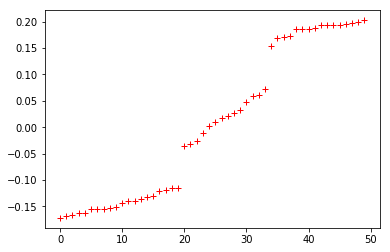

In [10]:
# observe three clusters
leading_eigvec_sort = np.sort(S_v[:,0])
plt.plot(leading_eigvec_sort,'r+')